In [70]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

import os
if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

from scripts.plotting_utils import (
    plot_geog_location, plot_xarray_on_map, 
)

from src.utils import drop_nans_and_flatten

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import logging 
mpl_logger = logging.getLogger('matplotlib') 
mpl_logger.setLevel(logging.WARNING) 

In [3]:
# set data and plot dir
if Path('.').absolute().owner() == 'tommylees':
    data_dir = Path('/Volumes/Lees_Extend/data/ecmwf_sowc/data')
    plot_dir = Path('/Users/tommylees/Downloads')
else:
    data_dir = Path('data')
    plot_dir = Path('.')  # ???

data_path = data_dir / "interim" / "chirps_preprocessed" / "chirps_kenya.nc"
analysis_path = data_dir / "analysis" 
all_indices_path = analysis_path / "indices" / "all_indices_kenya.nc"
vhi_path = data_dir / "interim" / "vhi_preprocessed" / "vhi_kenya.nc"
gleam_path = data_dir / "interim" / "gleam_preprocessed" / "gleam_kenya.nc"
era5_path = data_dir / "interim" / "era5POS_preprocessed" / "era5POS_kenya.nc"

[d.name for d in (data_dir/'interim').iterdir()]

['chirps_preprocessed',
 'era5POS_preprocessed',
 'gcloud',
 'gleam_preprocessed',
 's5_interim',
 's5_preprocessed',
 'TEMP',
 'vhi_interim',
 'vhi_preprocessed']

In [4]:
# open chirps precip (raw data file)
chirps = xr.open_dataset(data_path)
vhi = xr.open_dataset(vhi_path)
gleam = xr.open_dataset(gleam_path)
era5 = xr.open_dataset(era5_path)

# Calculate Annual CumSum

In [14]:
p_cumsum = chirps.groupby('time.year').apply(lambda x: x.cumsum(dim='time'))
p_cumsum['month'] = p_cumsum['time.month']
df = p_cumsum.mean(dim=['lat', 'lon']).to_dataframe()
df.head()

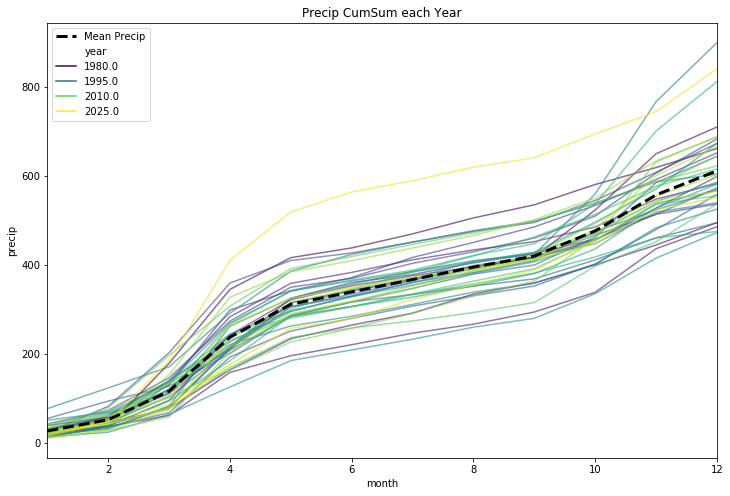

In [23]:
fig, ax = plt.subplots(figsize=(12,8))
(df.drop(columns='year').rename(columns={'precip': 'Mean Precip'})
 .groupby('month').mean()
 .plot(color='black', ls='--', lw=3, ax=ax, zorder=10)
)
sns.lineplot(x="month", y="precip", hue="year", data=df, alpha=0.6, ax=ax, palette='viridis')
ax.set_title('Precip CumSum each Year');

# Create Climatology for cumsum

In [32]:
from src.utils import create_shape_aligned_climatology

p_cumsum = chirps.groupby('time.year').apply(lambda x: x.cumsum(dim='time'))
clim = p_cumsum.groupby('time.month').mean(dim='time')
clim = create_shape_aligned_climatology(p_cumsum, clim, variable='precip', time_period='month')

In [35]:
pct_normal = (p_cumsum / clim) * 100
pct_normal

<xarray.Dataset>
Dimensions:  (lat: 224, lon: 176, time: 460)
Coordinates:
  * time     (time) datetime64[ns] 1981-01-31 1981-02-28 ... 2019-04-30
  * lat      (lat) float32 -5.175003 -5.125 -5.075001 ... 5.924999 5.9749985
  * lon      (lon) float32 33.524994 33.574997 33.625 ... 42.22499 42.274994
Data variables:
    precip   (time, lat, lon) float32 82.255486 80.879524 ... 32.623627

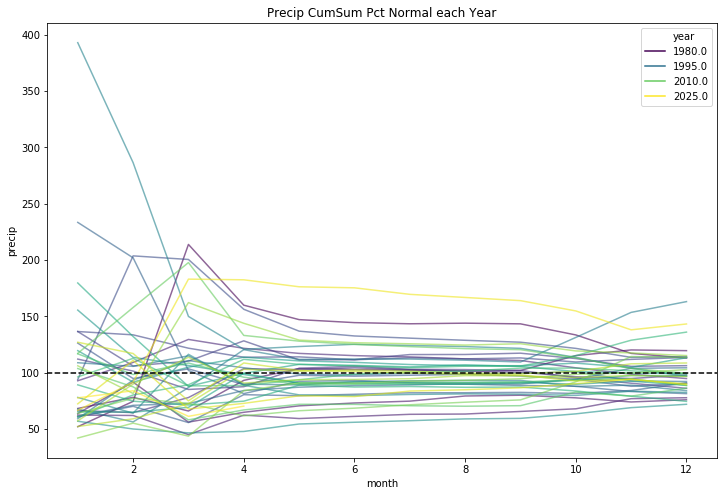

In [41]:
fig, ax = plt.subplots(figsize=(12,8))
pct_normal['month'], pct_normal['year'] = pct_normal['time.month'], pct_normal['time.year']
df_pct = pct_normal.mean(dim=['lat', 'lon']).to_dataframe()

sns.lineplot(x="month", y="precip", hue="year", data=df_pct, alpha=0.6, ax=ax, palette='viridis')
ax.set_title('Precip CumSum Pct Normal each Year');
ax.axhline(100, -1, ls='--', color='black');

Notice the variability in March/April. Because it is the rainy season and the rainy season is so variable, the variation around normal is large. Something happened that made one of the years a VERY wet January (somehwere in 1990s?). A tooltip would greatly help here because it would allow us to specify which year had which level of variability. 

He says confidently ...
I have just realised that because these are cumulative sums (starting from 0 at January) the % of variability will always be higher at the start of the year than the end. Let's try and prove it with some random number generation...

,precip,month,year
time,,,
1981-01-31,1156.972368,1.0,1981.0
1981-02-28,122.939587,2.0,1981.0
1981-03-31,209.488500,3.0,1981.0
1981-04-30,397.025702,4.0,1981.0
1981-05-31,1020.438163,5.0,1981.0


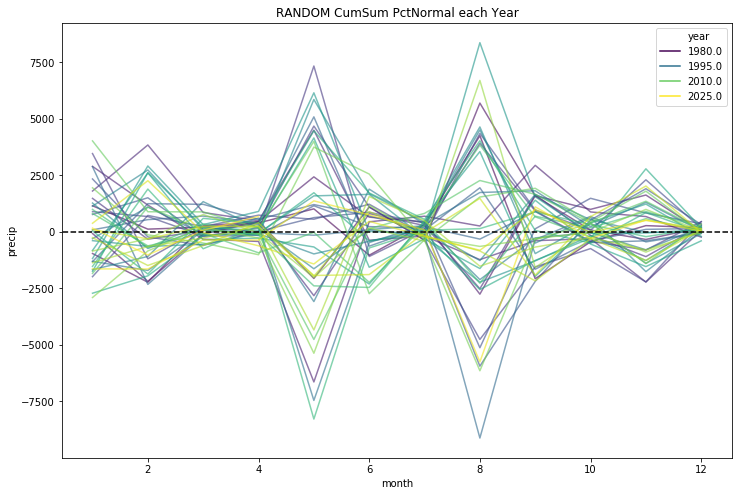

In [69]:
# create dimensions of xarray object
times = pd.date_range(start='1981-01-31', end='2019-04-30', freq='M')
lat = np.linspace(0, 1, 224)
lon = np.linspace(0, 1, 176)

rand_arr = np.random.randn(len(times), len(lat), len(lon))

# create xr.Dataset
coords = {'time': times, 'lat':lat, 'lon':lon}
dims = ['time', 'lat', 'lon']
rand_ds = xr.Dataset({'precip': (dims, rand_arr)}, coords=coords)
rand_ds['month'], rand_ds['year'] = rand_ds['time.month'], rand_ds['time.year']

# calculate cumsum
rand_cumsum = rand_ds.groupby('time.year').apply(lambda x: x.cumsum(dim='time'))

# create climatology
rand_clim = rand_cumsum.groupby('time.month').mean(dim='time')
rand_clim = create_shape_aligned_climatology(rand_cumsum, rand_clim, variable='precip', time_period='month')

# calculate % of normal
rand_pct = (rand_cumsum / rand_clim) * 100

# calculate time series of cumsum (spatial mean)
rand_pct['month'], rand_pct['year'] = rand_pct['time.month'], rand_pct['time.year']
rand = rand_pct.mean(dim=['lat', 'lon']).to_dataframe()

# to dataframe
rand = rand_pct.mean(dim=['lat', 'lon']).to_dataframe()
display(rand.head())

fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x="month", y="precip", hue="year", data=rand, alpha=0.6, ax=ax, palette='viridis')
ax.set_title('RANDOM CumSum PctNormal each Year');
ax.axhline(0, -1, ls='--', color='black');

# Just show histograms of rainfall distributions

Plotting Jan
Plotting Feb
Plotting Mar
Plotting Apr
Plotting May
Plotting Jun
Plotting Jul
Plotting Aug
Plotting Sep
Plotting Oct
Plotting Nov
Plotting Dec


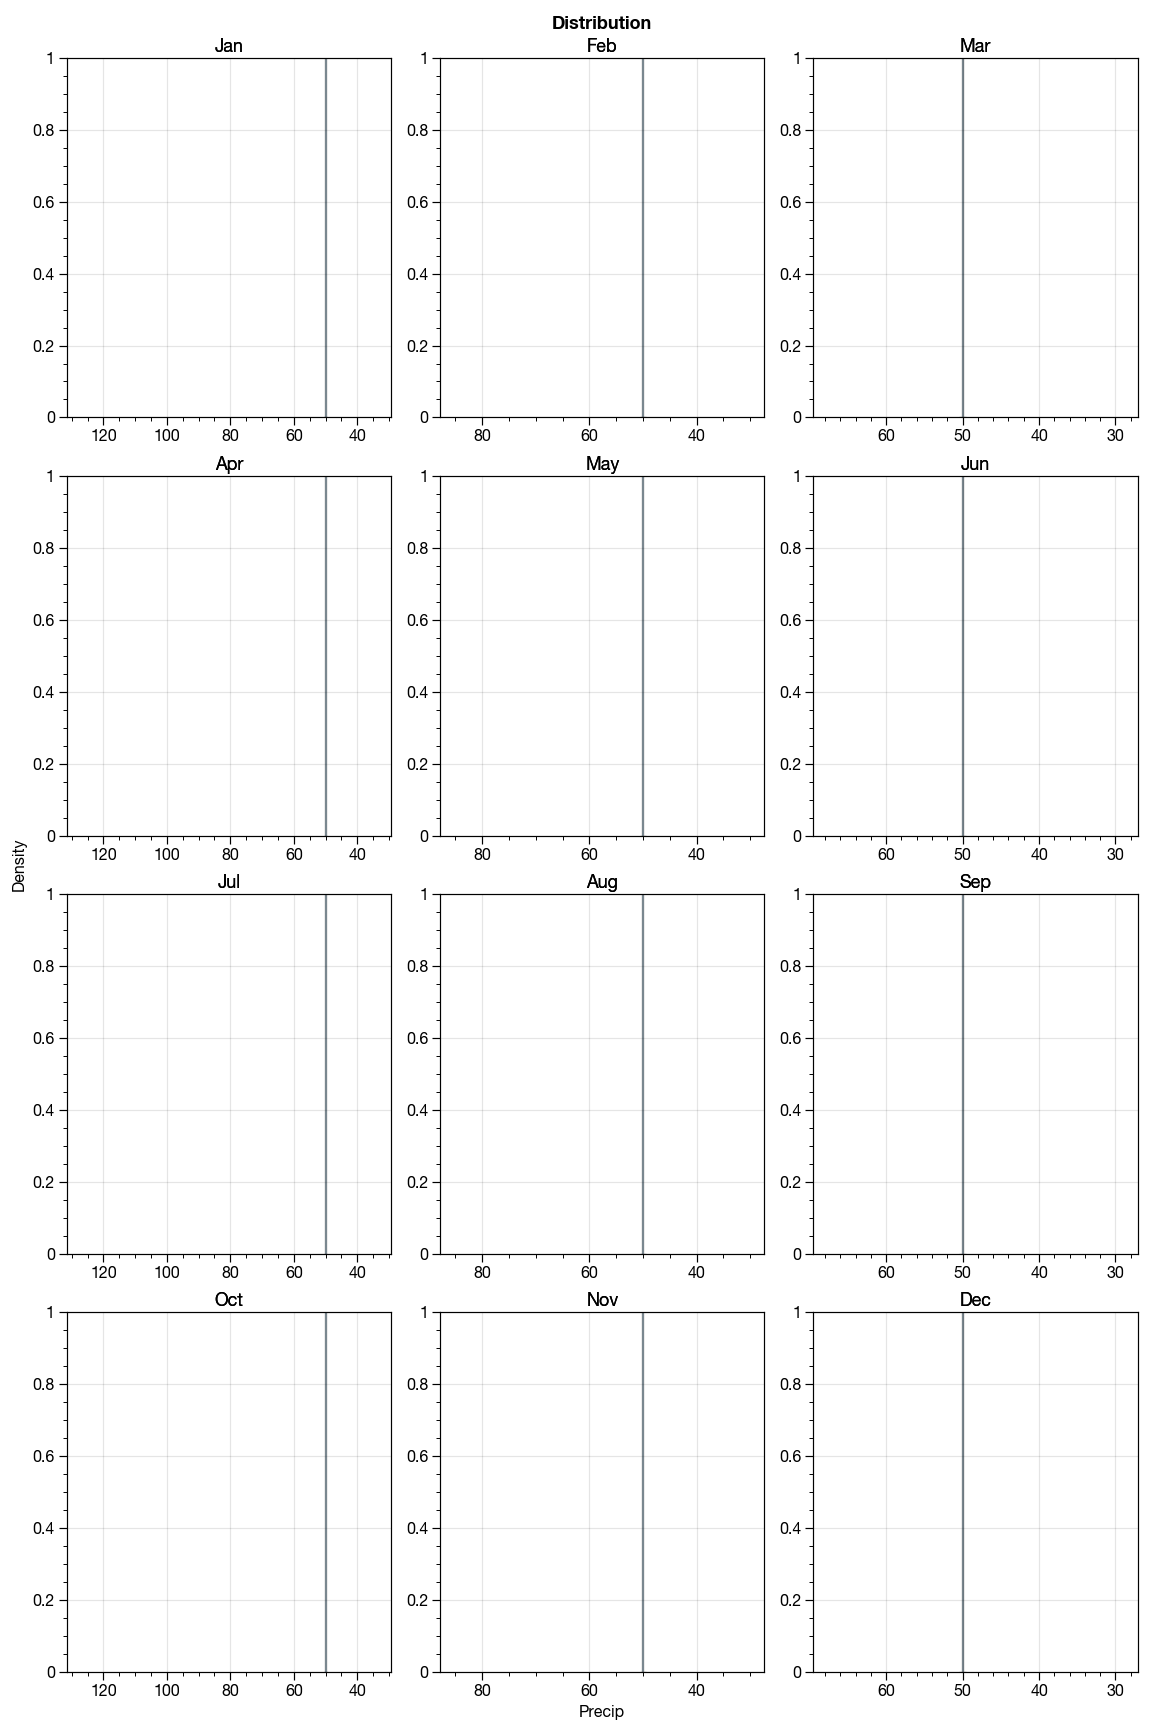

In [111]:
import proplot as plot
import calendar

f, axs = plot.subplots(nrows=4, ncols=3, axwidth=1.5, figsize=(8,12), share=2) # share=3, span=1,
axs.format(
    xlabel='Precip', ylabel='Density', suptitle='Distribution', 
)

month_abbrs = list(calendar.month_abbr)
mean_chirps = chirps.groupby('time.month').mean(dim='time')
flattened = []
for mth in np.arange(1, 13):
    ax = axs[mth - 1]
    ax.set_title(month_abbrs[mth])
    print(f"Plotting {month_abbrs[mth]}")
    flat = drop_nans_and_flatten(mean_chirps.sel(month=mth).precip)
    flattened.append(flat)
    sns.distplot(flat, ax=ax, **{'kde': False})

Text(0.5, 0.98, 'Distribution of Rainfall each Month')

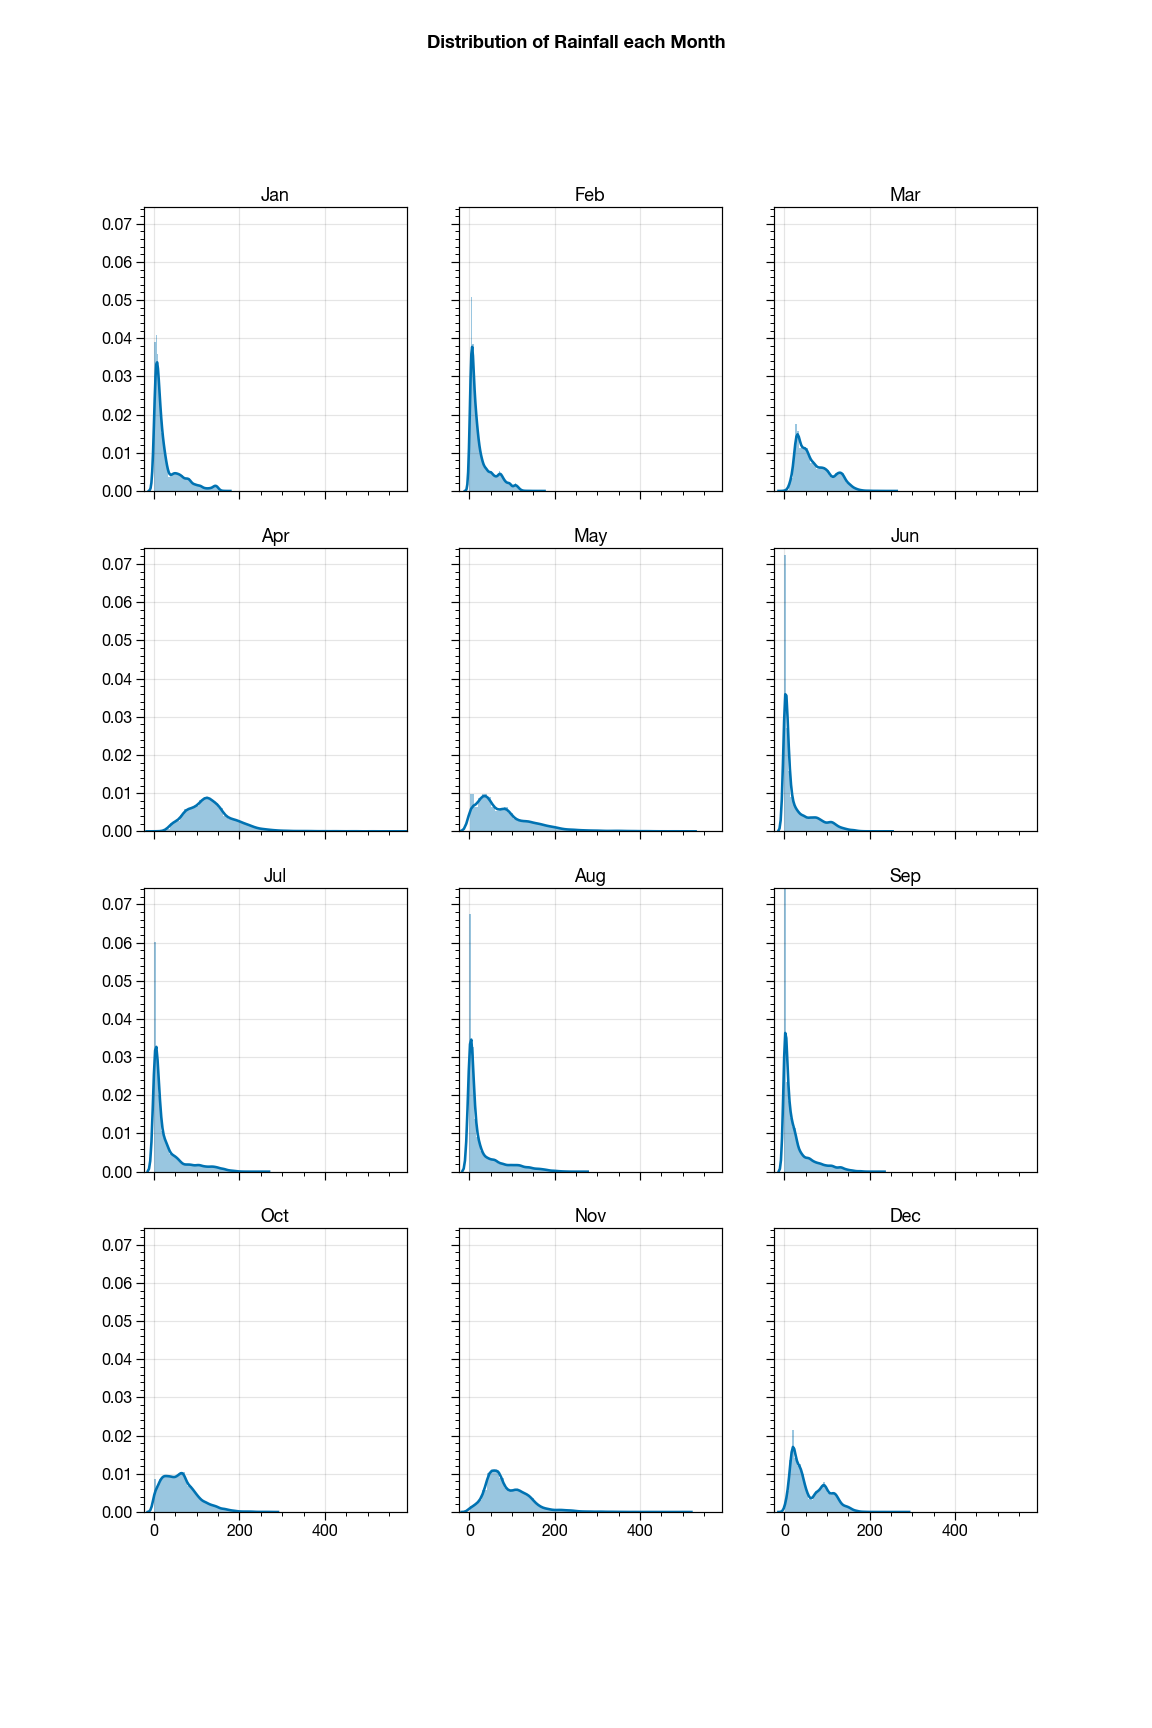

In [118]:
fig, axs = plt.subplots(4, 3, figsize=(8, 12), sharex=True, sharey=True)

month_abbrs = [m for m in calendar.month_abbr if m != '']

for mth in range(0, 12):
    ax_ix = np.unravel_index(mth, (4, 3))
    ax = axs[ax_ix]
    mth_str = month_abbrs[mth]
    sns.distplot(flattened[mth], ax=ax)
    ax.set_title(mth_str)

fig.suptitle('Distribution of Rainfall each Month');

# Github Issue with Proplot

In [119]:
# create dimensions of xarray object
times = pd.date_range(start='1981-01-31', end='2019-04-30', freq='M')
lat = np.linspace(0, 1, 224)
lon = np.linspace(0, 1, 176)

rand_arr = np.random.randn(len(times), len(lat), len(lon))

# create xr.Dataset
coords = {'time': times, 'lat':lat, 'lon':lon}
dims = ['time', 'lat', 'lon']
ds = xr.Dataset({'precip': (dims, rand_arr)}, coords=coords)
ds['month'], ds['year'] = ds['time.month'], ds['time.year']

Plotting Jan
Plotting Feb
Plotting Mar
Plotting Apr
Plotting May
Plotting Jun
Plotting Jul
Plotting Aug
Plotting Sep
Plotting Oct
Plotting Nov
Plotting Dec


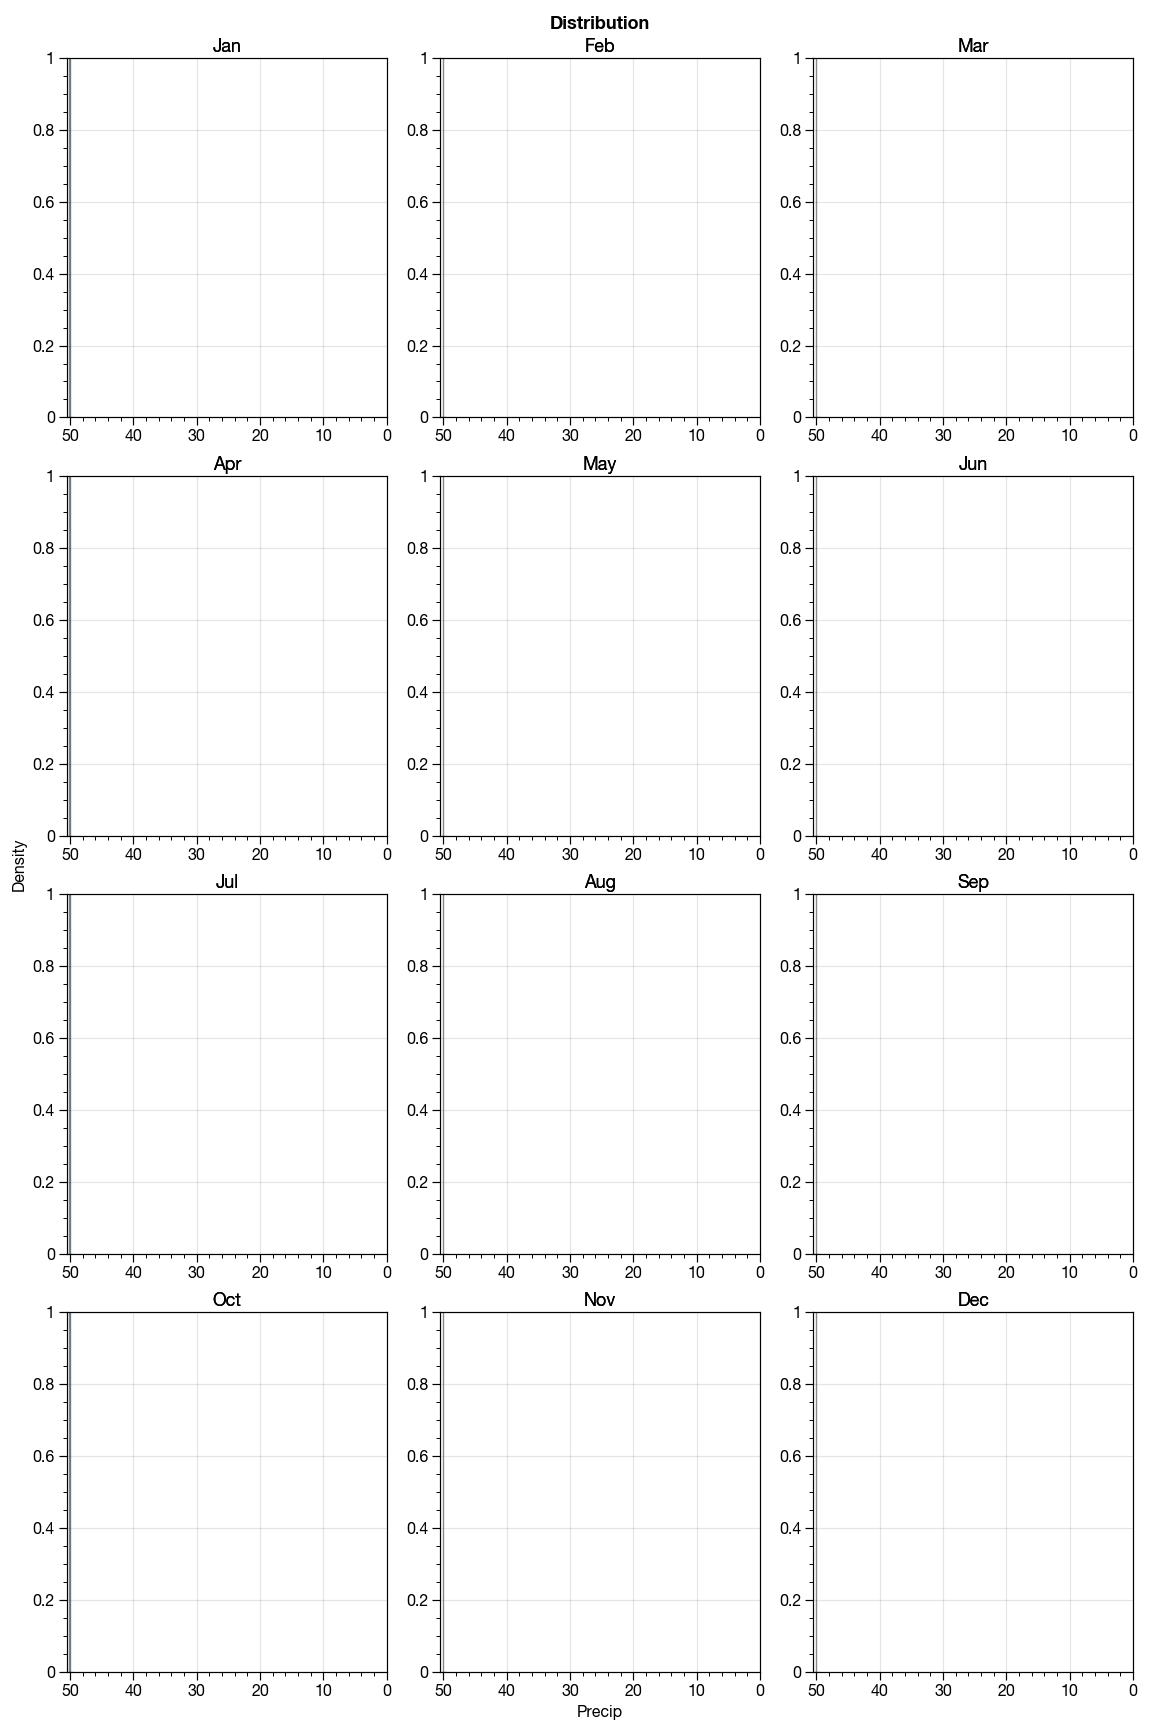

In [120]:
import proplot as plot
import calendar

f, axs = plot.subplots(nrows=4, ncols=3, axwidth=1.5, figsize=(8,12), share=2) # share=3, span=1,
axs.format(
    xlabel='Precip', ylabel='Density', suptitle='Distribution', 
)

month_abbrs = list(calendar.month_abbr)
mean_ds = ds.groupby('time.month').mean(dim='time')
flattened = []
for mth in np.arange(1, 13):
    ax = axs[mth - 1]
    ax.set_title(month_abbrs[mth])
    print(f"Plotting {month_abbrs[mth]}")
    flat = drop_nans_and_flatten(mean_ds.sel(month=mth).precip)
    flattened.append(flat)
    sns.distplot(flat, ax=ax, **{'kde': False})

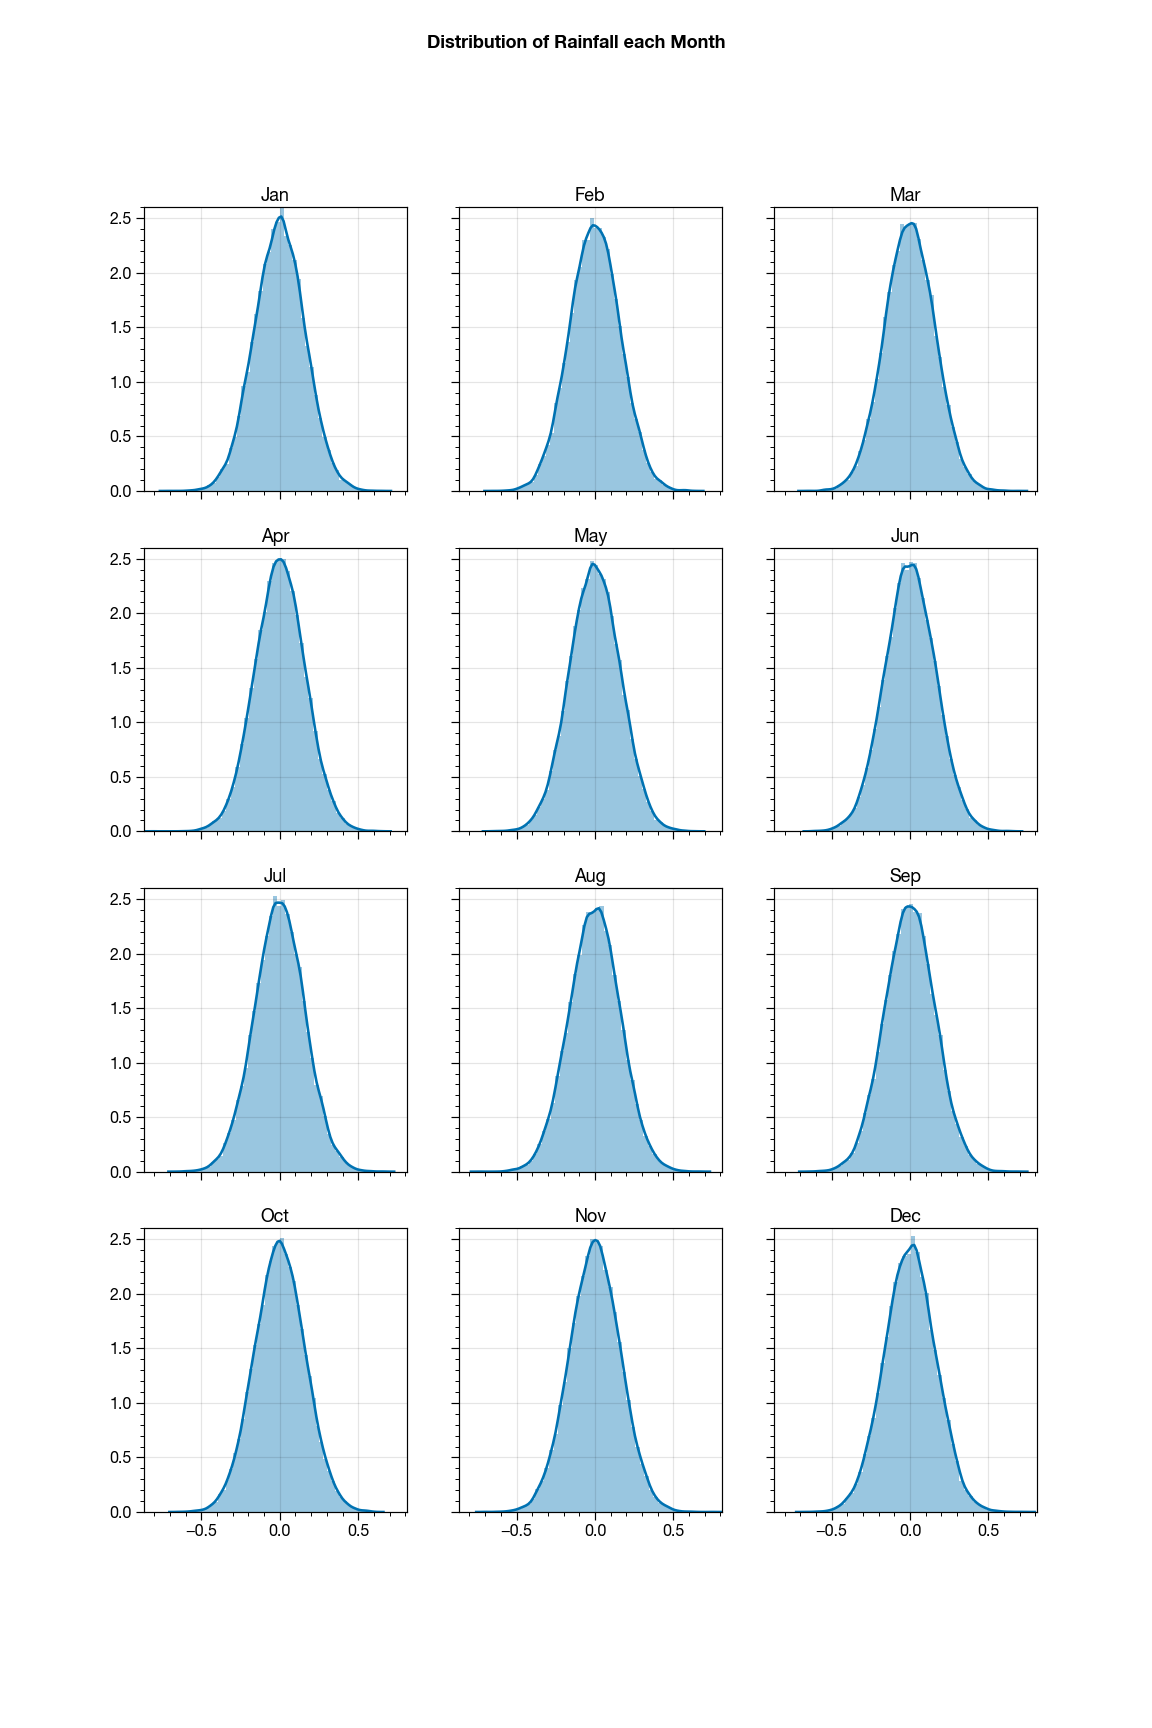

In [121]:
fig, axs = plt.subplots(4, 3, figsize=(8, 12), sharex=True, sharey=True)

month_abbrs = [m for m in calendar.month_abbr if m != '']

for mth in range(0, 12):
    ax_ix = np.unravel_index(mth, (4, 3))
    ax = axs[ax_ix]
    mth_str = month_abbrs[mth]
    sns.distplot(flattened[mth], ax=ax)
    ax.set_title(mth_str)

fig.suptitle('Distribution of Rainfall each Month');